In [153]:
import pandas as pd
import numpy as np
from pyjet import cluster,DTYPE_PTEPM
from sklearn import preprocessing
import tensorflow as tf

# Pre processing

In [154]:
path = '/anomalyvol/data/events_LHCO2020_backgroundMC_Pythia.h5'

In [155]:
df = pd.read_hdf(path,stop=100000) # just read first 10000 events

In [156]:
all_events = df.values

In [157]:
rows = all_events.shape[0]
cols = all_events.shape[1]
data = []

In [158]:
for i in range(rows):
    pseudojets_input = np.zeros(len([x for x in all_events[i][::3] if x > 0]), dtype=DTYPE_PTEPM)
    for j in range(cols // 3):
        if (all_events[i][j*3]>0):
            pseudojets_input[j]['pT'] = all_events[i][j*3]
            pseudojets_input[j]['eta'] = all_events[i][j*3+1]
            pseudojets_input[j]['phi'] = all_events[i][j*3+2]
        pass
    sequence = cluster(pseudojets_input, R=1.0, p=-1)
    jets = sequence.inclusive_jets()
    for k in range(len(jets)):
        jet = []
        jet.append(jets[k].px)
        jet.append(jets[k].py)
        jet.append(jets[k].pz)
        jet.append(jets[k].e)
        data.append(jet)

In [159]:
loaded_data = data
# data = loaded_data

In [160]:
data = np.array(data)
data.shape

(1477373, 4)

In [161]:
# log transform pT
#data[:,3] = np.ma.log(data[:,3]).filled()

In [162]:
data

array([[-1.17658220e+03, -7.79040316e+02,  3.40962660e+02,
         1.45491963e+03],
       [ 6.11088616e+02,  7.16513394e+02,  1.55833044e+03,
         1.87194199e+03],
       [ 4.96094722e+02, -1.87111748e+01,  1.78940558e+03,
         1.85808569e+03],
       ...,
       [ 4.42306312e-01,  9.70780337e-02,  2.58945478e+01,
         2.58985070e+01],
       [-2.68772115e-01, -3.44070287e-01, -3.01572220e+01,
         3.01603823e+01],
       [-2.82745626e-01, -7.48815701e-02, -9.38791569e+00,
         9.39247109e+00]])

In [163]:
# splitting data
x_train = data[0:int(len(data) * 0.8)]
x_val = data[int(len(data) * 0.8):int(len(data) * 0.9)]
x_test = data[int(len(data) * 0.9):]

In [164]:
# regularize
scaler = preprocessing.StandardScaler()
x_train = scaler.fit_transform(x_train)
x_val = scaler.transform(x_val)
x_test = scaler.transform(x_test)

# VAE Model

In [165]:
import keras
from keras.layers import Lambda, Input, Dense, Flatten, Reshape, LeakyReLU, ELU
from keras.models import Model, Sequential
from keras import metrics, losses
from keras import backend as K

In [166]:
def sampling(args):
    """
    # Arguments
        args (tensor): mean and log of variance of Q(z|X)
    # Returns
        z (tensor): sampled latent vector
    """

    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean = 0 and std = 1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

In [167]:
inter_dim_1 = 32
inter_dim_2 = 16
final_dim = 8
latent_dim = 2
input_dim = 4

In [168]:
# encoder
x = Input(shape=(input_dim,))
#x_flat = Flatten()(x)
h1 = Dense(inter_dim_1, activation='relu')(x)
h2 = Dense(inter_dim_2, activation='relu')(h1)
h3 = Dense(final_dim, activation='relu')(h2)
encoding = Dense(latent_dim, activation='tanh')(h3)

In [169]:
# decoder
decoder_h3 = Dense(final_dim, activation='relu')
decoder_h2 = Dense(inter_dim_2, activation='relu')
decoder_h1 = Dense(inter_dim_1, activation='relu')
decoder_mean = Dense(input_dim, activation='linear')

h3_decoded = decoder_h3(encoding)
h2_decoded = decoder_h2(h3_decoded)
h1_decoded = decoder_h1(h2_decoded)
x_decoded_mean = decoder_mean(h1_decoded)
# x_decoded = Reshape(input_shape)(x_decoded_mean)

In [170]:
vae = Model(inputs = x, outputs = x_decoded_mean, name = 'vae')

In [171]:
mse = keras.losses.MeanSquaredError()
def ae_loss(x, y):
    mse_loss = 0.25 * (16*(x[::,0] - y[::,0])**2 + 8*(x[::,1] - y[::,1])**2 + 1*(x[::,2] - y[::,2])**2 + 1*(x[::,3] - y[::,3])**2)
    # mse_loss = mse(x,y)
    return mse_loss

vae.compile(optimizer='adam', loss=ae_loss)

In [172]:
vae.summary()

Model: "vae"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 4)                 0         
_________________________________________________________________
dense_33 (Dense)             (None, 32)                160       
_________________________________________________________________
dense_34 (Dense)             (None, 16)                528       
_________________________________________________________________
dense_35 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_36 (Dense)             (None, 2)                 18        
_________________________________________________________________
dense_37 (Dense)             (None, 8)                 24        
_________________________________________________________________
dense_38 (Dense)             (None, 16)                144     

# Train

In [173]:
from sklearn.model_selection import train_test_split

In [174]:
batch_size = 1000
epochs = 200

In [175]:
x_train.shape

(1181898, 4)

In [176]:
my_callbacks = [
    keras.callbacks.EarlyStopping(patience=10)
]

In [177]:
hist = vae.fit(x_train, x_train,
               shuffle=True,
               epochs=epochs,
               batch_size=batch_size,
               validation_data=(x_val, x_val),
               callbacks=my_callbacks)

Train on 1181898 samples, validate on 147737 samples
Epoch 1/200
1181898/1181898 [==============================] - 7s 6us/step - loss: 0.7372 - val_loss: 0.3059
Epoch 2/200
1181898/1181898 [==============================] - 7s 6us/step - loss: 0.2984 - val_loss: 0.2963
Epoch 3/200
1181898/1181898 [==============================] - 7s 6us/step - loss: 0.2920 - val_loss: 0.2910
Epoch 4/200
1181898/1181898 [==============================] - 7s 6us/step - loss: 0.2881 - val_loss: 0.2882
Epoch 5/200
1181898/1181898 [==============================] - 7s 6us/step - loss: 0.2853 - val_loss: 0.2852
Epoch 6/200
1181898/1181898 [==============================] - 7s 6us/step - loss: 0.2840 - val_loss: 0.2843
Epoch 7/200
1181898/1181898 [==============================] - 7s 6us/step - loss: 0.2833 - val_loss: 0.2847
Epoch 8/200
1181898/1181898 [==============================] - 7s 6us/step - loss: 0.2828 - val_loss: 0.2834
Epoch 9/200
1181898/1181898 [==============================] - 7s 6us/step 

# Visualization

In [178]:
import matplotlib.pyplot as plt

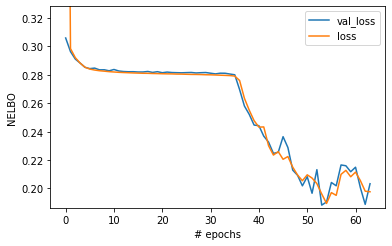

In [179]:
golden_size = lambda width: (width, 2. * width / (1 + np.sqrt(5)))

fig, ax = plt.subplots(figsize=golden_size(6))

hist_df = pd.DataFrame(hist.history)
hist_df.plot(ax=ax)

ax.set_ylabel('NELBO')
ax.set_xlabel('# epochs')

ax.set_ylim(.99*hist_df[1:].values.min(), 
            1.1*hist_df[1:].values.max())
plt.show()

In [180]:
predictions = vae.predict(x_test)

In [181]:
predictions

array([[ 0.00748137, -0.00655702,  0.01202089, -0.48182136],
       [ 0.01788619, -0.01825598, -0.10138243, -0.43115848],
       [ 0.01205901, -0.01584509,  0.04092413, -0.49369055],
       ...,
       [ 0.01431965, -0.01047161,  0.08204848, -0.47053677],
       [ 0.01422238, -0.00090364, -0.01117903, -0.4693628 ],
       [ 0.01242121, -0.00854281,  0.01778024, -0.4840873 ]],
      dtype=float32)

In [182]:
distr = (x_test - predictions) / x_test

In [183]:
px_pred = [row[0] for row in predictions]
py_pred = [row[1] for row in predictions]
pz_pred = [row[2] for row in predictions]
e_pred = [row[3] for row in predictions]

In [184]:
px = [row[0] for row in x_test]
py = [row[1] for row in x_test]
pz = [row[2] for row in x_test]
e = [row[3] for row in x_test]

In [185]:
overall_distr = K.flatten(distr)
overall_pred = K.flatten(predictions)
overall_input = K.flatten(x_test)

(array([  666.,   666.,   747.,   821.,   795.,   841.,   894.,   927.,
          988.,  1079.,  1171.,  1233.,  1294.,  1503.,  1659.,  1789.,
         1866.,  2105.,  2407.,  2847., 25776., 38774., 20914., 15580.,
         9403.,  7320., 13614., 55351., 26509., 12288., 10052., 13247.,
        10927.,  7941.,  5637.,  4071.,  4787.,  4269.,  3279.,  2757.,
         2412.,  2351.,  2129.,  1942.,  1807.,  1639.,  1538.,  1426.,
         1316.]),
 array([-0.1       , -0.09591837, -0.09183673, -0.0877551 , -0.08367347,
        -0.07959184, -0.0755102 , -0.07142857, -0.06734694, -0.06326531,
        -0.05918367, -0.05510204, -0.05102041, -0.04693878, -0.04285714,
        -0.03877551, -0.03469388, -0.03061224, -0.02653061, -0.02244898,
        -0.01836735, -0.01428571, -0.01020408, -0.00612245, -0.00204082,
         0.00204082,  0.00612245,  0.01020408,  0.01428571,  0.01836735,
         0.02244898,  0.02653061,  0.03061224,  0.03469388,  0.03877551,
         0.04285714,  0.04693878,  0.05

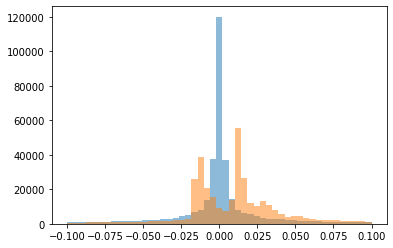

In [186]:
# overall pred vs input
bins = np.linspace(-0.1, 0.1, 50)
plt.hist(overall_input, bins=bins,alpha=0.5)
plt.hist(overall_pred, bins=bins,alpha=0.5)

(array([  2527.,   2844.,   3077.,   3162.,   3515.,   3773.,   4292.,
          4649.,   5376.,   7018.,   8658.,  10863.,  17118.,  33208.,
        135039.,  19902.,  14360.,  11557.,  10710.,   9232.,   9297.,
          9516.,   7481.,   5921.,   4928.,   4422.,   4223.,   3601.,
          3466.]),
 array([-2.        , -1.86206897, -1.72413793, -1.5862069 , -1.44827586,
        -1.31034483, -1.17241379, -1.03448276, -0.89655172, -0.75862069,
        -0.62068966, -0.48275862, -0.34482759, -0.20689655, -0.06896552,
         0.06896552,  0.20689655,  0.34482759,  0.48275862,  0.62068966,
         0.75862069,  0.89655172,  1.03448276,  1.17241379,  1.31034483,
         1.44827586,  1.5862069 ,  1.72413793,  1.86206897,  2.        ]),
 <a list of 29 Patch objects>)

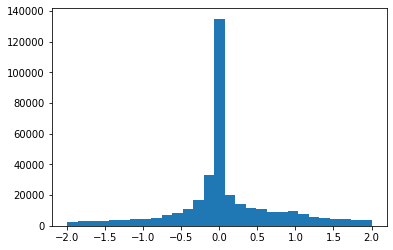

In [187]:
# overall distr
bins = np.linspace(-2, 2, 30)
plt.hist(overall_distr, bins=bins)

## Stacking output (orange) over input (blue) for pT, eta, phi, m

(array([   94.,   115.,   101.,   109.,    99.,   120.,   134.,   150.,
          174.,   212.,   219.,   230.,   248.,   297.,   300.,   329.,
          409.,   491.,   481.,   671.,   715.,   895.,  1316.,  1986.,
         4125., 32447., 56517.,  7455.,  2463.,  1720.,  1187.,   896.,
          714.,   672.,   540.,   487.,   364.,   347.,   305.,   274.,
          263.,   242.,   194.,   215.,   159.,   177.,   159.,   152.,
          133.]),
 array([-0.2       , -0.19183673, -0.18367347, -0.1755102 , -0.16734694,
        -0.15918367, -0.15102041, -0.14285714, -0.13469388, -0.12653061,
        -0.11836735, -0.11020408, -0.10204082, -0.09387755, -0.08571429,
        -0.07755102, -0.06938776, -0.06122449, -0.05306122, -0.04489796,
        -0.03673469, -0.02857143, -0.02040816, -0.0122449 , -0.00408163,
         0.00408163,  0.0122449 ,  0.02040816,  0.02857143,  0.03673469,
         0.04489796,  0.05306122,  0.06122449,  0.06938776,  0.07755102,
         0.08571429,  0.09387755,  0.10

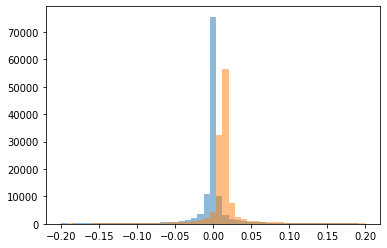

In [188]:
bins = np.linspace(-0.2, 0.2, 50)
plt.hist(px, bins=bins,alpha=0.5)
plt.hist(px_pred, bins=bins,alpha=0.5)

In [189]:
print(mse(px,px_pred))

tf.Tensor(0.0013007484, shape=(), dtype=float32)


(array([   85.,    96.,   130.,   132.,   153.,   160.,   173.,   159.,
          199.,   238.,   245.,   321.,   356.,   422.,   515.,   622.,
          675.,   803.,   972.,  1313.,  1512.,  2171., 44683., 41993.,
        12749.,  2705.,  1862.,  1311.,  1036.,   860.,   675.,   455.,
          416.,   385.,   431.,   429.,   414.,   304.,   233.,   161.,
          150.,   125.,   113.,   103.,   114.,    99.,    79.,    90.,
           79.]),
 array([-0.2       , -0.19183673, -0.18367347, -0.1755102 , -0.16734694,
        -0.15918367, -0.15102041, -0.14285714, -0.13469388, -0.12653061,
        -0.11836735, -0.11020408, -0.10204082, -0.09387755, -0.08571429,
        -0.07755102, -0.06938776, -0.06122449, -0.05306122, -0.04489796,
        -0.03673469, -0.02857143, -0.02040816, -0.0122449 , -0.00408163,
         0.00408163,  0.0122449 ,  0.02040816,  0.02857143,  0.03673469,
         0.04489796,  0.05306122,  0.06122449,  0.06938776,  0.07755102,
         0.08571429,  0.09387755,  0.10

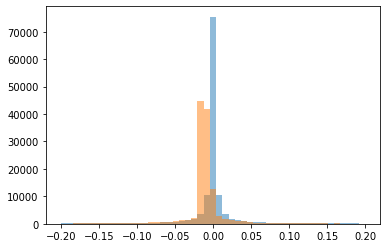

In [190]:
bins = np.linspace(-0.2, 0.2, 50)
plt.hist(py, bins=bins,alpha=0.5)
plt.hist(py_pred, bins=bins,alpha=0.5)

In [191]:
print(mse(py,py_pred))

tf.Tensor(0.012774699, shape=(), dtype=float32)


(array([  292.,   327.,   343.,   363.,   376.,   426.,   459.,   479.,
          488.,   545.,   577.,   620.,   666.,   683.,   771.,   793.,
          959.,  1000.,  1195.,  1342.,  1710.,  2162.,  3237.,  4806.,
         9202., 27858., 26811., 11828.,  6505.,  4216.,  3018.,  2162.,
         1698.,  1298.,  1120.,   972.,   824.,   711.,   615.,   570.,
          573.,   473.,   449.,   425.,   393.,   343.,   327.,   366.,
          345.]),
 array([-0.5       , -0.47959184, -0.45918367, -0.43877551, -0.41836735,
        -0.39795918, -0.37755102, -0.35714286, -0.33673469, -0.31632653,
        -0.29591837, -0.2755102 , -0.25510204, -0.23469388, -0.21428571,
        -0.19387755, -0.17346939, -0.15306122, -0.13265306, -0.1122449 ,
        -0.09183673, -0.07142857, -0.05102041, -0.03061224, -0.01020408,
         0.01020408,  0.03061224,  0.05102041,  0.07142857,  0.09183673,
         0.1122449 ,  0.13265306,  0.15306122,  0.17346939,  0.19387755,
         0.21428571,  0.23469388,  0.25

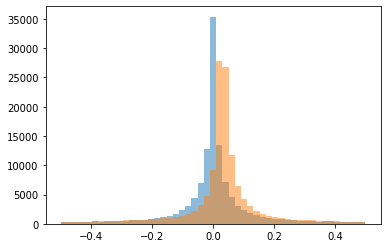

In [192]:
bins = np.linspace(-0.5, 0.5, 50)
plt.hist(pz, bins=bins,alpha=0.5)
plt.hist(pz_pred, bins=bins,alpha=0.5)

In [193]:
print(mse(pz,pz_pred))

tf.Tensor(0.5867234, shape=(), dtype=float32)


(array([0.0000e+00, 3.0000e+01, 2.1100e+02, 6.4199e+04, 2.0297e+04,
        1.0065e+04, 5.1490e+03, 3.4760e+03, 2.4800e+03, 1.9650e+03,
        1.6270e+03, 1.3140e+03, 1.1210e+03, 1.0090e+03, 8.9800e+02,
        7.6500e+02, 7.2100e+02, 6.5200e+02, 4.9300e+02, 4.9600e+02,
        4.6800e+02, 4.3400e+02, 4.4000e+02, 4.5200e+02, 4.4100e+02,
        3.6100e+02, 3.1100e+02, 2.4200e+02, 1.9100e+02, 1.4500e+02,
        1.3300e+02, 1.2300e+02, 1.0300e+02, 9.4000e+01, 7.6000e+01,
        6.3000e+01, 8.4000e+01, 7.4000e+01, 5.3000e+01, 6.0000e+01,
        4.9000e+01, 4.9000e+01, 4.8000e+01, 4.0000e+01, 4.5000e+01,
        3.3000e+01, 2.8000e+01, 3.6000e+01, 2.5000e+01]),
 array([-0.55      , -0.53265306, -0.51530612, -0.49795918, -0.48061224,
        -0.46326531, -0.44591837, -0.42857143, -0.41122449, -0.39387755,
        -0.37653061, -0.35918367, -0.34183673, -0.3244898 , -0.30714286,
        -0.28979592, -0.27244898, -0.25510204, -0.2377551 , -0.22040816,
        -0.20306122, -0.18571429, -0.1

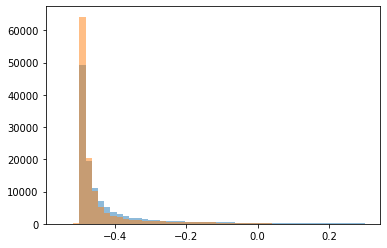

In [194]:
bins = np.linspace(-0.55,0.3, 50)
plt.hist(e, bins=bins,alpha=0.5)
plt.hist(e_pred, bins=bins,alpha=0.5)

In [195]:
print(mse(e,e_pred))

tf.Tensor(0.092389844, shape=(), dtype=float32)


In [196]:
d_px = [row[0] for row in distr]
d_py = [row[1] for row in distr]
d_pz = [row[2] for row in distr]
d_e = [row[3] for row in distr]

## Distribution of (input - output) / input

In [197]:
bins = np.linspace(-2, 2, 30)

(array([  671.,   667.,   749.,   728.,   802.,   854.,  1021.,  1161.,
         1350.,  1636.,  2015.,  1817.,  1899.,  3586., 21075.,  3993.,
         2502.,  1742.,  1529.,  1249.,  1155.,  1046.,  1022.,   974.,
          886.,   808.,   790.,   698.,   716.]),
 array([-2.        , -1.86206897, -1.72413793, -1.5862069 , -1.44827586,
        -1.31034483, -1.17241379, -1.03448276, -0.89655172, -0.75862069,
        -0.62068966, -0.48275862, -0.34482759, -0.20689655, -0.06896552,
         0.06896552,  0.20689655,  0.34482759,  0.48275862,  0.62068966,
         0.75862069,  0.89655172,  1.03448276,  1.17241379,  1.31034483,
         1.44827586,  1.5862069 ,  1.72413793,  1.86206897,  2.        ]),
 <a list of 29 Patch objects>)

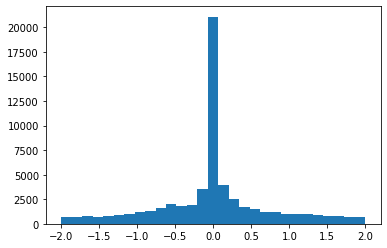

In [198]:
plt.hist(d_px, bins=bins)

(array([  652.,   719.,   733.,   743.,   804.,   830.,   920.,   874.,
          975.,  1079.,  1172.,  1394.,  1760.,  2997., 14616.,  6816.,
         3246.,  2729.,  2614.,  2426.,  2502.,  2255.,  1935.,  1764.,
         1532.,  1443.,  1393.,  1225.,  1167.]),
 array([-2.        , -1.86206897, -1.72413793, -1.5862069 , -1.44827586,
        -1.31034483, -1.17241379, -1.03448276, -0.89655172, -0.75862069,
        -0.62068966, -0.48275862, -0.34482759, -0.20689655, -0.06896552,
         0.06896552,  0.20689655,  0.34482759,  0.48275862,  0.62068966,
         0.75862069,  0.89655172,  1.03448276,  1.17241379,  1.31034483,
         1.44827586,  1.5862069 ,  1.72413793,  1.86206897,  2.        ]),
 <a list of 29 Patch objects>)

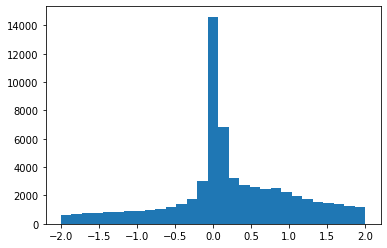

In [199]:
plt.hist(d_py, bins=bins)

(array([1010., 1249., 1338., 1387., 1501., 1607., 1814., 1955., 2217.,
        3049., 3574., 4068., 4657., 5554., 6279., 5972., 6321., 5539.,
        5618., 5123., 5455., 6035., 4294., 2951., 2281., 1985., 1852.,
        1520., 1449.]),
 array([-2.        , -1.86206897, -1.72413793, -1.5862069 , -1.44827586,
        -1.31034483, -1.17241379, -1.03448276, -0.89655172, -0.75862069,
        -0.62068966, -0.48275862, -0.34482759, -0.20689655, -0.06896552,
         0.06896552,  0.20689655,  0.34482759,  0.48275862,  0.62068966,
         0.75862069,  0.89655172,  1.03448276,  1.17241379,  1.31034483,
         1.44827586,  1.5862069 ,  1.72413793,  1.86206897,  2.        ]),
 <a list of 29 Patch objects>)

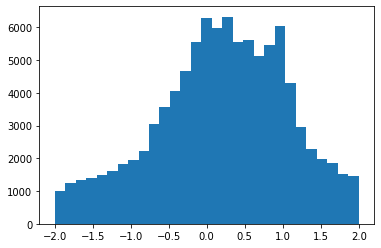

In [200]:
plt.hist(d_pz, bins=bins)

(array([  194.,   209.,   257.,   304.,   408.,   482.,   537.,   659.,
          834.,  1254.,  1897.,  3584.,  8802., 21071., 93069.,  3121.,
         2291.,  1547.,   949.,   434.,   185.,   180.,   230.,   232.,
          229.,   186.,   188.,   158.,   134.]),
 array([-2.        , -1.86206897, -1.72413793, -1.5862069 , -1.44827586,
        -1.31034483, -1.17241379, -1.03448276, -0.89655172, -0.75862069,
        -0.62068966, -0.48275862, -0.34482759, -0.20689655, -0.06896552,
         0.06896552,  0.20689655,  0.34482759,  0.48275862,  0.62068966,
         0.75862069,  0.89655172,  1.03448276,  1.17241379,  1.31034483,
         1.44827586,  1.5862069 ,  1.72413793,  1.86206897,  2.        ]),
 <a list of 29 Patch objects>)

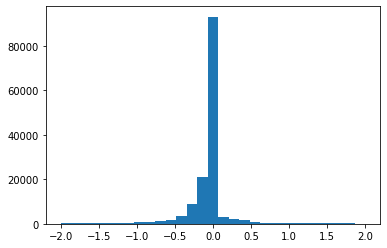

In [201]:
plt.hist(d_e, bins=bins)